# Lecture 4: Class demo

## Image classification using KNNs and SVM RBF

For this demonstration I'm using a subset of [Kaggle's Animal Faces dataset](https://www.kaggle.com/datasets/andrewmvd/animal-faces). I've put this subset in our [course GitHub repository](https://github.com/UBC-CS/cpsc330-2023W1/tree/main/lectures/data/animal_faces). 

The code in this notebook is a bit complicated and you are not expected to understand all the code. 

## Imports

In [1]:
import sys

sys.path.append("../code/.")

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from plotting_functions import *
from sklearn.model_selection import cross_validate, train_test_split
from utils import *

In [2]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision import datasets, models, transforms, utils
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(seed=42)   

Let's proceed with reading the data. Since we don't have tabular data, we are using a slightly more complex method to read it. You don't need to understand the code provided below.

In [4]:
import glob
IMAGE_SIZE = 200
def read_img_dataset(data_dir):     
    """
    Reads and preprocesses an image dataset from the specified directory.

    Args:
        data_dir (str): The directory path where the dataset is located.

    Returns:
        inputs (Tensor): A batch of preprocessed input images.
        classes (Tensor): The corresponding class labels for the input images.
    """    
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0 
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [5]:
def plot_sample_imgs(inputs):
    plt.figure(figsize=(10, 70)); plt.axis("off"); plt.title("Sample Training Images")
    plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [6]:
train_dir = "../data/animal_faces/train" # training data
file_names = [image_file for image_file in glob.glob(train_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
X_anim_train, y_train = read_img_dataset(train_dir)
n_images

150

In [7]:
valid_dir = "../data/animal_faces/valid" # valid data
file_names = [image_file for image_file in glob.glob(valid_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
X_anim_valid, y_valid = read_img_dataset(valid_dir)
n_images

150

In [8]:
X_train = X_anim_train.numpy()
X_valid = X_anim_valid.numpy()

Let's examine some of the sample images. 

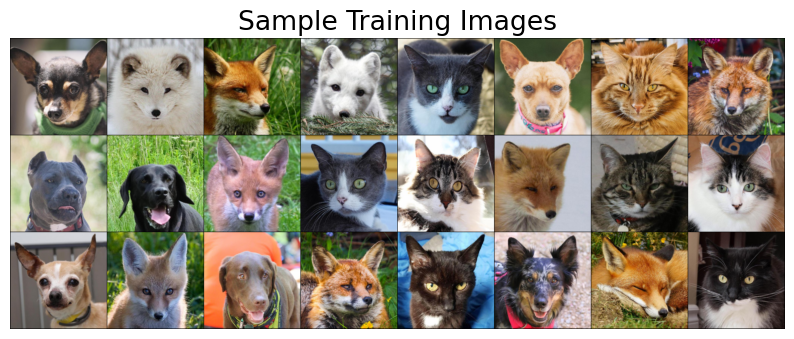

In [9]:
plot_sample_imgs(X_anim_train[0:24,:,:,:])

With K-nearest neighbours (KNN), we will attempt to classify an animal face into one of three categories: cat, dog, or wild animal. The idea is that when presented with a new animal face image, we want the model to assign it to one of these three classes based on its similarity to other images within each of these classes.

To train a KNN model, we require tabular data. How can we transform image data, which includes height and width information, into tabular data with meaningful numerical values?

<br><br>

Flattening images and feeding them to K-nearest neighbors (KNN) is one approach. However, in this demonstration, we will explore an alternative method. We will employ a pre-trained image classification model known as 'desenet' to obtain a 1024-dimensional meaningful representation of each image. The function provided below accomplishes this task for us. Once again, you are not required to comprehend the code.

In [10]:
def get_features(model, inputs):
    """
    Extracts features from a pre-trained DenseNet model.

    Args:
        model (torch.nn.Module): A pre-trained DenseNet model.
        inputs (torch.Tensor): Input data for feature extraction.

    Returns:
        torch.Tensor: Extracted features from the model.
    """   
    
    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_train = torch.cat((Z_train, model(inputs)), dim=0)
    return Z_train.detach().numpy()

In [11]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = torch.nn.Identity()  # remove that last "classification" layer

In [12]:
X_train.shape

(150, 3, 200, 200)

In [13]:
# Get representations of the train images
Z_train = get_features(
    densenet, X_anim_train, 
)

We now have tabular data. 

In [14]:
Z_train.shape

(150, 1024)

In [15]:
pd.DataFrame(Z_train)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.000236,0.004594,0.001687,0.002321,0.161429,0.816200,0.000812,0.003663,0.259521,0.000420,...,0.874960,1.427516,1.242741,0.026616,0.210286,0.974181,0.898244,0.904565,0.067099,0.182383
1,0.000128,0.001419,0.002848,0.000313,0.066512,0.442917,0.000423,0.002802,0.056599,0.000839,...,0.805414,0.029396,0.049097,0.319482,0.086078,2.516787,0.864291,3.109578,0.384528,0.046114
2,0.000235,0.006070,0.003593,0.002643,0.098787,0.091632,0.000441,0.003044,0.365898,0.000241,...,0.259086,0.239082,0.084684,1.902341,1.206019,1.027080,0.259026,3.334765,0.428280,0.414406
3,0.000248,0.002965,0.002921,0.000428,0.075668,0.331588,0.000520,0.002987,0.245635,0.000374,...,0.485191,0.157572,0.215167,1.478514,0.014989,0.526782,0.642071,2.119190,1.498164,0.365925
4,0.000296,0.003463,0.001230,0.000890,0.076018,0.726441,0.000685,0.002921,0.194914,0.000281,...,0.449264,0.176027,0.578569,0.152691,0.632296,1.519129,0.781977,0.974532,0.302044,0.614872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.000270,0.006250,0.003785,0.002418,0.180926,0.199412,0.000480,0.002477,0.232075,0.000187,...,1.692130,0.727992,0.119121,1.040561,1.431104,0.219714,0.945967,0.758030,0.921435,0.544079
146,0.000316,0.006208,0.003540,0.004469,0.200458,0.398915,0.000475,0.004852,0.196963,0.000329,...,0.620726,1.681430,0.857458,4.337626,0.583973,0.015639,0.373318,0.286326,0.610142,3.533027
147,0.000432,0.001375,0.003088,0.003877,0.154883,0.298043,0.000934,0.001566,0.265483,0.000540,...,0.218867,0.324762,0.039739,3.903425,0.145186,0.221760,1.000561,0.298437,2.578452,0.468994
148,0.000540,0.008286,0.001882,0.001109,0.140371,0.856722,0.000387,0.003272,0.202247,0.000310,...,0.303694,1.546152,2.726269,0.000000,0.495523,0.592505,0.539258,1.308236,0.090579,3.543677


In [16]:
# Get representations of the validation images
Z_valid = get_features(
    densenet, X_anim_valid, 
)

In [17]:
Z_valid.shape

(150, 1024)

<br><br>

### Dummy model

Let's examine the baseline accuracy. 

In [18]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, Z_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.000977,0.000544,0.333333,0.333333
1,0.000206,0.000222,0.333333,0.333333
2,0.000172,0.000208,0.333333,0.333333
3,0.000154,0.000201,0.333333,0.333333
4,0.000147,0.000197,0.333333,0.333333


## Classification with `KNeighborsClassifier`

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
pd.DataFrame(cross_validate(knn, Z_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.001140,0.103175,0.966667,0.991667
1,0.000966,0.008489,1.000000,0.991667
2,0.000513,0.001647,0.933333,0.983333
3,0.000501,0.002283,0.933333,0.991667
4,0.000355,0.001255,0.933333,1.000000


This is with the default `n_neighbors`. Let's optimize `n_neighbors`. 

In [20]:
knn.get_params()['n_neighbors']

5

In [21]:
n_neighbors = np.arange(1, 15, 1).tolist()

results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}

for k in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, Z_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

In [22]:
results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("n_neighbors")
results_df

,mean_train_score,mean_cv_score,std_cv_score,std_train_score
n_neighbors,,,,
1,1.000000,0.966667,0.021082,0.000000
2,0.988333,0.953333,0.016330,0.006667
3,0.993333,0.953333,0.016330,0.006236
4,0.985000,0.953333,0.016330,0.012247
5,0.991667,0.953333,0.026667,0.005270
6,0.976667,0.940000,0.024944,0.014337
7,0.980000,0.946667,0.016330,0.008498
8,0.968333,0.940000,0.038873,0.020000
9,0.968333,0.926667,0.032660,0.019293


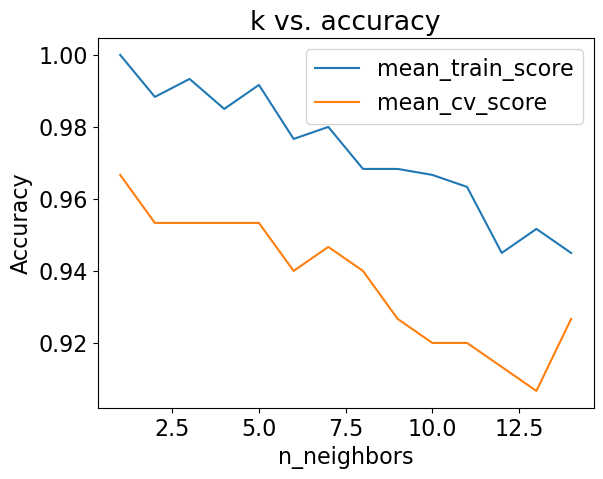

In [23]:
results_df[['mean_train_score', 'mean_cv_score']].plot(ylabel='Accuracy', title="k vs. accuracy");

In [24]:
best_k = n_neighbors[np.argmax(results_df['mean_cv_score'])]
best_k

1

Is SVC performing better than k-NN? 

In [25]:
C_values = np.logspace(-1, 2, 4)
cv_scores = []
train_scores = []

for C_val in C_values:
    print('C = ', C_val)
    svc = SVC(C=C_val)
    scores = cross_validate(svc, Z_train, y_train, return_train_score=True)
    cv_scores.append(scores['test_score'].mean())
    train_scores.append(scores['train_score'].mean())    

C =  0.1
C =  1.0
C =  10.0
C =  100.0


In [26]:
results_df = pd.DataFrame({"cv": cv_scores, 
                           "train": train_scores},index = C_values)
results_df

,cv,train
0.1,0.973333,0.993333
1.0,1.000000,1.000000
10.0,1.000000,1.000000
100.0,1.000000,1.000000


In [27]:
best_C = C_values[np.argmax(results_df['cv'])]
best_C

1.0

It's not realistic but we are getting perfect CV accuracy with `C=10` and `C=100` on our toy dataset. `sklearn`'s default `C =1.0` didn't give us the best cv score. 

Let's go back to KNN and manually examine the nearest neighbours. 

What are the nearest neighbors?

In [28]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
nn.fit(Z_train)

NearestNeighbors()

In [29]:
# You do not have to understand this code. 
def show_nearest_neighbors(test_idx, nn, Z, X, y):
    distances, neighs = nn.kneighbors([Z[test_idx]])
    neighbors = neighs.ravel()
    plt.figure(figsize=(2,2), dpi=80)
    query_img = X[test_idx].transpose(1, 2, 0)
    plt.title('Query image', size=12)
    plt.imshow(np.clip(query_img, 0, 255));
    plt.xticks(())
    plt.yticks(())    
    plt.show()
    
    fig, axes = plt.subplots(1, 5, figsize=(10,4), subplot_kw={'xticks':(), 'yticks':()})
    print('Nearest neighbours:')
    
    for ax, dist, img_ind in zip(axes.ravel(), distances.ravel(), neighbors):
        img = X_train[img_ind].transpose(1, 2, 0)
        ax.imshow(np.clip(img, 0, 255))
        ax.set_title('distance: '+ str(round(dist,3)), size=10 )
    plt.show()

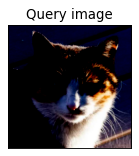

Nearest neighbours:


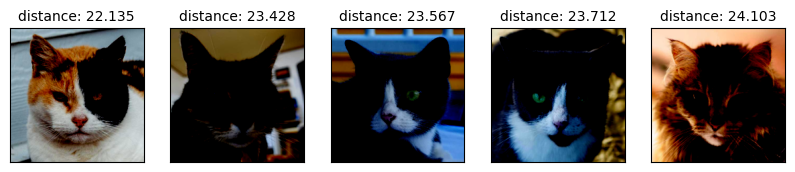

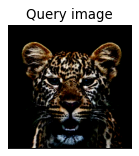

Nearest neighbours:


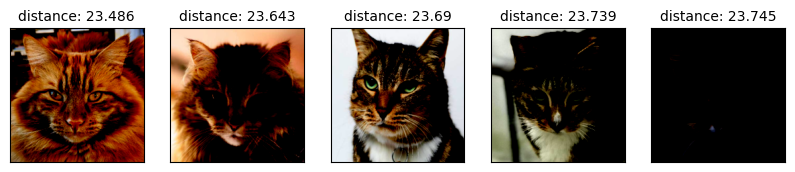

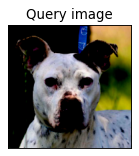

Nearest neighbours:


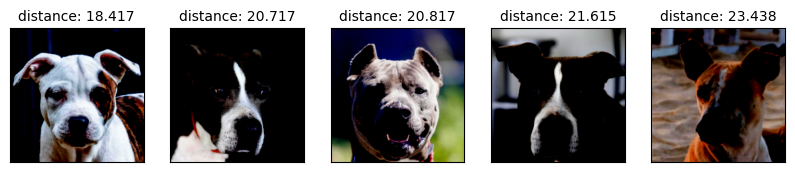

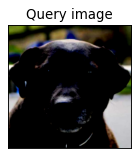

Nearest neighbours:


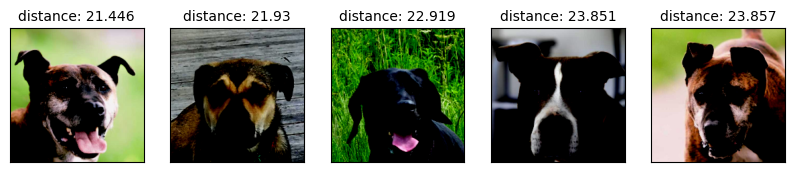

In [30]:
test_idx = [1,10,100,140]
for idx in test_idx: 
    show_nearest_neighbors(idx, nn, Z_valid, X_valid, y_valid)